In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
#determine most recent date in database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date

'2017-08-23'

In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

temp_data = calc_temps('2017-08-01','2017-08-07')
temp_data

[(72.0, 79.25, 83.0)]

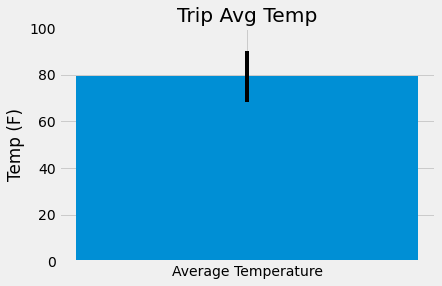

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_axis = 'Average Temperature'

plt.xlabel('')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0,100)

yerr = temp_data[0][2]-temp_data[0][0]
temp_avg = temp_data[0][1]

plt.bar(x_axis, temp_avg, yerr=yerr)

plt.show()

### Daily Rainfall Average

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    group_by(Measurement.station).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= '2017-08-01').\
    filter(Measurement.date <= '2017-08-07').\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
rain

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.22),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]

### Daily Temperature Normals

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
from datetime import date, timedelta
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start_date = date(2017, 8, 1)
end_date = date(2017, 8, 7)

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d

delta = end_date - start_date

date_list = []

for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    date_list.append(day.strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals = []

for date in date_list:
    daily_normal_result = daily_normals(date)
    normals.append(daily_normal_result)

In [18]:
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin_list = []
tavg_list = []
tmax_list = []

for i in normals:
    
    tmin = i[0][0]
    tavg = i[0][1]
    tmax = i[0][2]
    
    tmin_list.append(tmin)
    tavg_list.append(tavg)
    tmax_list.append(tmax)


In [20]:
normals_df = pd.DataFrame(list(zip(date_list, tmin_list, tavg_list, tmax_list)), columns = ['date','min', 'avg', 'max'])

normals_df = normals_df.set_index('date')

normals_df

,min,avg,max
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


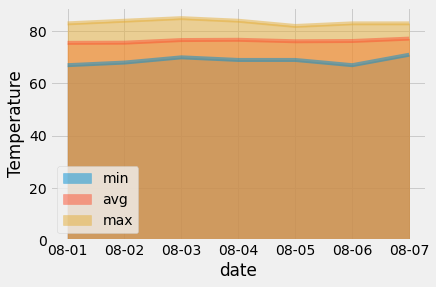

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(x=None, y=None, stacked=False)

plt.ylabel('Temperature')
plt.legend(loc='lower left')

plt.show()

## Close Session

In [22]:
session.close()